Model loaded
Data loaded and preprocessed! Shape: (424, 15)
Model Evaluation:
MAE: 162685.57
RMSE: 228625.48
R²: 0.98


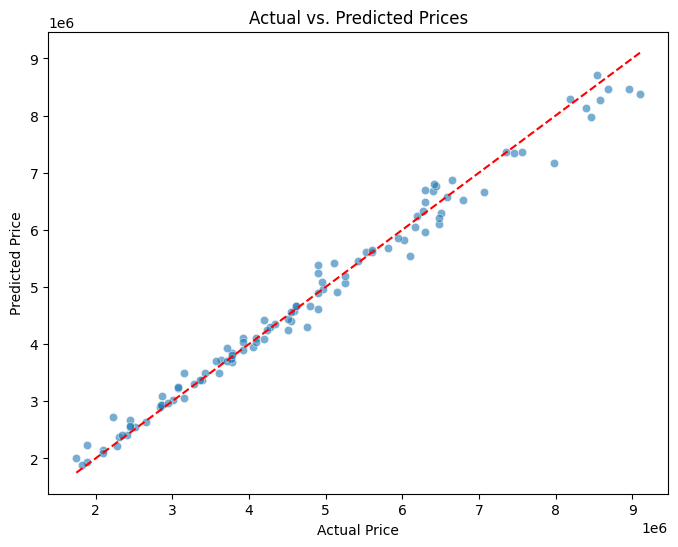

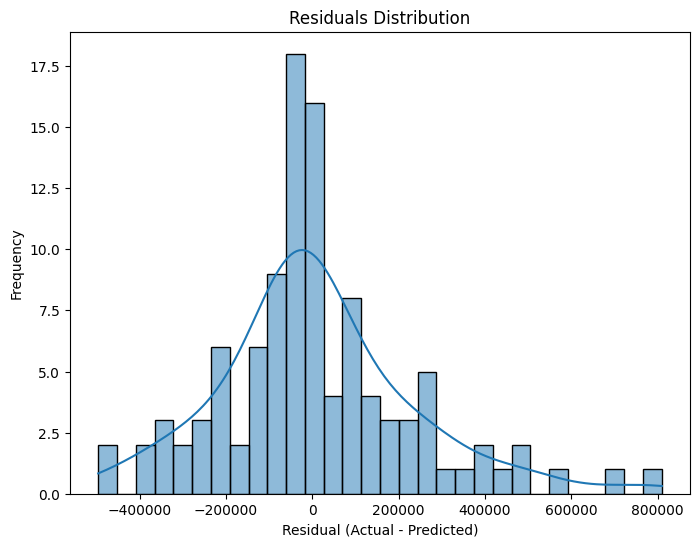

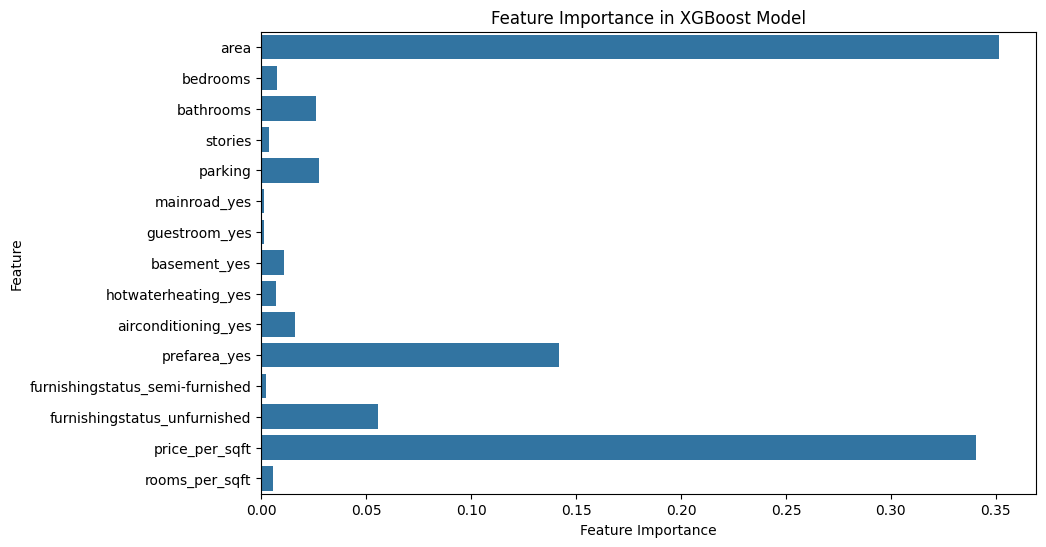

In [5]:
import joblib
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# Load model
model_path = os.path.join("..", "reports", "xgboost_model.pkl")
model = joblib.load(model_path)
print("Model loaded")

# Load and preprocess data
data_path = os.path.join("..", "data", "Housing.csv")
df = pd.read_csv(data_path)
df = pd.get_dummies(df, drop_first=True)

# Handle outliers
Q1 = df["price"].quantile(0.25)
Q3 = df["price"].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df = df[(df["price"] >= lower_bound) & (df["price"] <= upper_bound)]

# Feature Engineering
df["price_per_sqft"] = df["price"] / (df["area"] + 1)
df["rooms_per_sqft"] = df["bedrooms"] / (df["area"] + 1)

# Define Features and Target
X = df.drop(columns=["price"])
y = np.log1p(df["price"])

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize Numerical Features (using the same scaler as before)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Data loaded and preprocessed! Shape: {X_train.shape}")

# Make predictions
y_pred = model.predict(X_test_scaled)
y_pred_actual = np.expm1(y_pred)  # Convert back from log scale
y_test_actual = np.expm1(y_test)  # Convert back from log scale

# Evaluate the model
mae = mean_absolute_error(y_test_actual, y_pred_actual)
rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred_actual))
r2 = r2_score(y_test_actual, y_pred_actual)

print(f"Model Evaluation:\nMAE: {mae:.2f}\nRMSE: {rmse:.2f}\nR²: {r2:.2f}")

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test_actual, y=y_pred_actual, alpha=0.6)
plt.plot([min(y_test_actual), max(y_test_actual)], [min(y_test_actual), max(y_test_actual)], color="red", linestyle="--")
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs. Predicted Prices")
plt.show()

residuals = y_test_actual - y_pred_actual

plt.figure(figsize=(8, 6))
sns.histplot(residuals, bins=30, kde=True)
plt.xlabel("Residual (Actual - Predicted)")
plt.ylabel("Frequency")
plt.title("Residuals Distribution")
plt.show()


importances = model.feature_importances_
features = X.columns

plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=features)
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Feature Importance in XGBoost Model")
plt.show()


